In [ ]:
! pip install -q pytorch-lightning && pip install efficientnet-pytorch

     |████████████████████████████████| 552kB 15.3MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
     |████████████████████████████████| 276kB 56.7MB/s 
     |████████████████████████████████| 829kB 50.3MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=2ea907f546286c47c90b0f62912b537987fc7eff3e964f29405066560a844f26
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torchsummary import summary
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

import random

from PIL import Image
import cv2
import sklearn
from sklearn.metrics import roc_curve, auc, log_loss, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib as mplb 
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd 

from tensorflow.keras.utils import to_categorical
import os 
import zipfile
import shutil
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings(action='ignore')

#Keras 
from keras.utils import to_categorical



# Getting datasets

In [4]:
class_names = ['NEG', 'POS']
data_dir = '/content/drive/My Drive/ZindiTuberculosisChallenge'
base_dir = '/content'

# create dirs 
PATHS = {
    'cwd': '/content/', #Current directory
    'arch': '/content/MODELS/', #Folder in which we're going to save our models
    'raw': '/content/data/Csv/', #Folder containing the training files
    'images': '/content/data/Zip/Images/train/', #this folder is going to store our images files
    'test_images' : '/content/data/Zip/Images/test/'
    }

os.makedirs(PATHS['arch'], exist_ok=True)


seed_val = 2020 # for reproductibility
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
# extract files
files_base_path = os.path.join(data_dir, 'data', 'Zip')

def extract_files(task='train', dest = '/content/data/Zip/Images'):
  src = f"{files_base_path}/{task}"
  dest = os.path.join(dest, f'{task}')
  try:
      with zipfile.ZipFile(f"{src}.zip", 'r') as zip_ref:
          # Loop over each file
          for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist()), desc="Extrating files"):

              # Extract each file to another directory
              # If you want to extract to current working directory, don't specify path
              zip_ref.extract(member=file, path=dest)
          # print('[INFO] Done !')
      
  except Exception as ex:
      print(f'[ERROR] {ex}')
        


# split files into classes

def create_training_folders(images_path='/content/data/Zip/Images/train/train'):
    images = [img for img in os.listdir(images_path) if len(img.split('.'))>1]

    base_path  = images_path

    for imag in tqdm(images, desc='Moving files'):
        img_path = os.path.join(base_path, imag)
        try:
          label = train_df.loc[train_df['ID'] == imag.split('.')[0]].values[0][2]

          if label == 1:
              src = img_path
              dest = os.path.join(base_path, 'positive')
              try:
                  shutil.move(src, dest)
              except Exception as ex:
                  print(f'[ERROR] {ex}')
          else:
              src = img_path
              dest = os.path.join(base_path, 'negative')
              try:
                  shutil.move(src, dest)
              except Exception as ex:
                  print(f'[ERROR] {ex}')
        except:
          pass



In [6]:
extract_files(task='train')
extract_files(task='test')


In [16]:

train_csv_path = os.path.join(base_dir, 'data/Csv', 'Train.csv')
test_csv_path = os.path.join(base_dir, 'data/Csv', 'Test.csv')
sample_csv_path = os.path.join(base_dir, 'data/Csv', 'Train.csv')

# move uploaded files 
try:
  files_to_move = ['Test.csv', 'Train.csv', 'SampleSubmission.csv'] 
  for f in files_to_move:
    shutil.move(src = os.path.join(base_dir, f), dst=os.path.join(base_dir, 'data/Csv', f))
except:
  os.makedirs('/content/data/Csv')
  files_to_move = ['Test.csv', 'Train.csv', 'SampleSubmission.csv'] 
  for f in files_to_move:
    shutil.move(src = os.path.join(base_dir, f), dst=os.path.join(base_dir, 'data/Csv', f))

## Classes definition

In [8]:
class TBDataset(torch.utils.data.Dataset):
    def __init__(self, df, task='train', size=(300, 230), use_tfms=True, **kwargs):
        super(TBDataset, self).__init__()
        self.df = df
        self.task = task
        self.size = size
        self.use_tfms = use_tfms
        self.c = 2

        self.train_transforms = transforms.Compose([
          transforms.ToPILImage(),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),

        ])
        self.transform = transforms.Compose([
          transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fn = self.df.loc[idx, 'filename']
        img = cv2.imread(os.path.join(PATHS['images'], fn))
        img = cv2.resize(img, self.size)

        if self.use_tfms: 
          img = self.train_transforms(img)
        else:
          img = self.transform(img)

        output = {
              'image': img,
          }

        if self.task == 'train':
            label = self.df.loc[idx, 'LABEL']
            output.update({
              'label': torch.tensor( to_categorical(label, self.c), dtype=torch.float )
          })

        return output
    
    

    
    
    
    
class TBModel(torch.nn.Module):
    def __init__(self, arch_name, pretrained=True, layer='fc', fc_size=512, out_size=2):
        super(TBModel, self).__init__()


        self.arch = getattr(models, arch_name)(pretrained)
        self.num_ftr = getattr(self.arch, layer).in_features
        self.classifier = nn.Sequential(
            torch.nn.Linear(self.num_ftr, out_size)
        )
        setattr(self.arch, layer, self.classifier)

        torch.nn.init.xavier_normal_(getattr(getattr(self.arch, layer)[0], 'weight'))

    def forward(self, x):
        x = self.arch(x)
        x = torch.sigmoid(x)

        return x

## Functions definition

In [11]:
def training_fn(dataloader, model, opt, criterion, epoch):
    avg_loss = 0
    avg_acc = 0
    avg_auc = 0
    # pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}')
    model.to(device)

    
    model.train()

    for i, data in enumerate(dataloader):
        x,y = data['image'].to(device), data['label'].to(device)

        opt.zero_grad()

        pred = model(x)
        loss = criterion(pred, y)


        avg_loss += loss
        avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()

        _, y = torch.max(y, 1)
        _, pred = torch.max(pred, 1)
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true=y.cpu().detach().numpy(), y_score = pred.cpu().detach().numpy(), pos_label=1)
        avg_auc += sklearn.metrics.auc(fpr, tpr)

        loss.backward()
        opt.step()

        # pbar.set_postfix(Loss=str(loss.cpu().detach().numpy()), OvrAllLoss=str(avg_loss.cpu().detach().numpy()/(i+1)),
        #                  OvrAllAcc=str(avg_acc.cpu().detach().numpy()/(i+1)), 
        #                  AvgLogLoss=str(avg_logloss/(i+1)))
        # pbar.update()
        
    avg_loss_nump = avg_loss.cpu().detach().numpy()
    avg_acc_nump = avg_acc.cpu().detach().numpy()

    print('[Training] Epoch {} : Loss: {:.5f} - Acc : {:.5f} - AUC : {:.5f}'.format(epoch, avg_loss_nump/len(dataloader), avg_acc_nump/len(dataloader), avg_auc/len(dataloader)))
    
    
                    ################## evaluation Function ####################   

def evaluate(dataloader, model, criterion):
  avg_loss = 0
  avg_acc = 0
  avg_logloss = 0
  avg_auc = 0
  model.eval()

  with torch.no_grad():
    for data in dataloader:
      x = data['image'].to(device)
      y = data['label'].to(device)
      pred = model(x)
      loss = criterion(pred, y)


      avg_loss += loss
      avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()

      _, y = torch.max(y, 1)
      _, pred = torch.max(pred, 1)
      fpr, tpr, _ = sklearn.metrics.roc_curve(y_true=y.cpu().detach().numpy(), y_score = pred.cpu().detach().numpy(), pos_label=1)
      avg_auc += sklearn.metrics.auc(fpr, tpr)

      avg_loss /= len(dataloader)
      avg_acc /= len(dataloader)

    print('[Evaluation] Loss: {:.5f} - Acc : {:.5f} - AUC : {:.5f}'.format(avg_loss.cpu().detach().numpy(),
                                                                           avg_acc.cpu().detach().numpy(), 
                                                                           avg_auc / len(dataloader)))

    return avg_loss, avg_auc/len(dataloader), avg_acc


                ################## prediction Function ####################   


def predict(df, size, MODELS, bs=8):

  test_ds = TBDataset(df, task='test', size=size, use_tfms=False)
  testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

  predictions_labels = []
  predictions_proba = []

  out = None

  for data in tqdm(testloader):
    x = data['image'].to(device)

    for i in range(n_folds):
      if i == 0: out = MODELS[i](x)
      else: out += MODELS[i](x)

      out /= n_folds
      out_labels = out.argmax(1).cpu().detach().numpy()
      out_probas = out.cpu().detach().numpy()

      predictions_labels += out_labels.tolist()
      predictions_proba += out_probas.tolist()

  return predictions_labels ,predictions_proba


        ################## Run training over folds Function ####################   


def run_fold(train:pd.DataFrame,  
            fold, bs=16, 
             eval_bs=8,
             device='cuda', 
             lr=1e-4, 
             size=(300, 230), 
             arch='resnet34', 
             layer='fc', 
             epochs=15,
             fc_size=512,
             path=PATHS['arch']):
  
    
  best_logloss = np.inf
  best_auc = 0
  best_acc = 0

  fold_train = train[train.fold != fold].reset_index(drop=True)
  fold_val = train[train.fold == fold].reset_index(drop=True)

  train_ds = TBDataset(fold_train, size=size)
  val_ds = TBDataset(fold_val, size=size, use_tfms=False)

  trainloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
  validloader = torch.utils.data.DataLoader(val_ds, batch_size=eval_bs, shuffle=False)

  model = TBModel(arch, layer=layer, fc_size=fc_size)
  criterion = torch.nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=lr)


  loader = tqdm(range(epochs), desc=f'Training on fold {fold+1}')

  for epoch in loader:

    training_fn(trainloader, model, opt, criterion, epoch)
    avg_logloss, avg_auc, avg_acc = evaluate(validloader, model, criterion)

    if avg_auc > best_auc:
      best_auc = avg_auc
      torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')
    
    elif avg_acc > best_acc :
      best_acc = avg_acc
      torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')

  del model

  return best_auc



                ################## training Function ####################   

def load_models(arch='resnet34', 
                layer='fc', 
                fc_size=512,  
                path=PATHS['arch']):
    
  MODELS = []
    
  for i in range(n_folds):
    MODELS.append( MaskModel(arch_name=arch, layer=layer, fc_size=fc_size) )
    MODELS[i].to(device)
    MODELS[i].load_state_dict(torch.load(f'{path}model_state_dict_{i}.bin'))
    MODELS[i].eval()
        
    return MODELS

## Dataframes loading

In [17]:
train = pd.read_csv(PATHS['raw']+'Train.csv')
train.head()

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0
2,train/PMRSQLXN.png,PMRSQLXN,0
3,train/JXISWDUU.png,JXISWDUU,1
4,train/JVWMAACC.png,JVWMAACC,1


## Train/val split

In [22]:
train_images_list = train['filename'].tolist() #convert images column into list

images_list = os.listdir(PATHS['images']+'train/')
test_images_list = [fn for fn in os.listdir(PATHS['test_images']+'test')]

sub = pd.DataFrame(test_images_list, columns=['image'])
sub['LABEL'] = 0

# Add file names
train['filepath'] = PATHS['images']+train['filename']
sub['filepath'] = PATHS['test_images']+'test/'+sub['image']



In [23]:
train.head()

,filename,ID,LABEL,filepath
0,train/VTYNBFTO.png,VTYNBFTO,1,/content/data/Zip/Images/train/train/VTYNBFTO.png
1,train/GVVXXDOZ.png,GVVXXDOZ,0,/content/data/Zip/Images/train/train/GVVXXDOZ.png
2,train/PMRSQLXN.png,PMRSQLXN,0,/content/data/Zip/Images/train/train/PMRSQLXN.png
3,train/JXISWDUU.png,JXISWDUU,1,/content/data/Zip/Images/train/train/JXISWDUU.png
4,train/JVWMAACC.png,JVWMAACC,1,/content/data/Zip/Images/train/train/JVWMAACC.png


In [ ]:
sub.head()

,image,LABEL,filepath
0,VXDFSKHL.png,0,/content/data/Zip/Images/test/test/VXDFSKHL.png
1,WVTDEKEX.png,0,/content/data/Zip/Images/test/test/WVTDEKEX.png
2,ZKETEOFG.png,0,/content/data/Zip/Images/test/test/ZKETEOFG.png
3,LWOMGDGX.png,0,/content/data/Zip/Images/test/test/LWOMGDGX.png
4,CGBUGUQW.png,0,/content/data/Zip/Images/test/test/CGBUGUQW.png


In [ ]:
len(train), len(sub)

(718, 82)

### Create data folds for cross-validation

In [25]:
n_folds = 10 # number of folds used

train['fold'] = 0

#creating our folds using a special class of Scikit-learn
fold = sklearn.model_selection.StratifiedKFold(n_splits = n_folds, random_state=seed_val)

for i, (tr, vr) in enumerate(fold.split(train, train['LABEL'])):
    train.loc[vr, 'fold'] = i



In [26]:
train.head()

,filename,ID,LABEL,filepath,fold
0,train/VTYNBFTO.png,VTYNBFTO,1,/content/data/Zip/Images/train/train/VTYNBFTO.png,0
1,train/GVVXXDOZ.png,GVVXXDOZ,0,/content/data/Zip/Images/train/train/GVVXXDOZ.png,0
2,train/PMRSQLXN.png,PMRSQLXN,0,/content/data/Zip/Images/train/train/PMRSQLXN.png,0
3,train/JXISWDUU.png,JXISWDUU,1,/content/data/Zip/Images/train/train/JXISWDUU.png,0
4,train/JVWMAACC.png,JVWMAACC,1,/content/data/Zip/Images/train/train/JVWMAACC.png,0


In [20]:
size = (300, 300)          # image size
epochs = 15                # training epochs
device = 'cuda'            # in order to run model on GPU
size = (300, 300)          # image size
arch = 'resnet50'       # pre-trained model architecture used
layer = 'fc'
fc_size = 2208             # Fully connected layer size
bs = 32                    # training Batch size
eval_bs = 4                # Evaluation Batch size
lr = 1e-4    

train_ds = TBDataset(train, size=size)
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)

model = TBModel(arch, layer=layer, fc_size=fc_size)
criterion = torch.nn.BCELoss()
opt = torch.optim.AdamW(model.parameters(), lr=lr)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [27]:
run_fold(train=train, fold=3, epochs = 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


[Training] Epoch 0 : Loss: 0.49636 - Acc : 0.78506 - AUC : 0.79732
[Evaluation] Loss: 0.06044 - Acc : 0.09546 - AUC : nan


KeyboardInterrupt: ignored

## Data viz

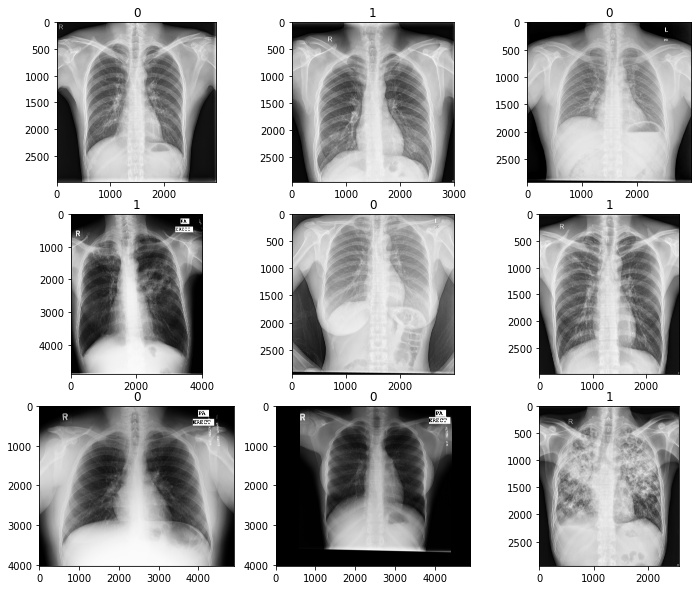

In [ ]:
#Training images
nrows = 3
rands = np.random.randint(len(train_images_list), size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(os.path.join(PATHS['images'], train.loc[rands[i], 'filename']))
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

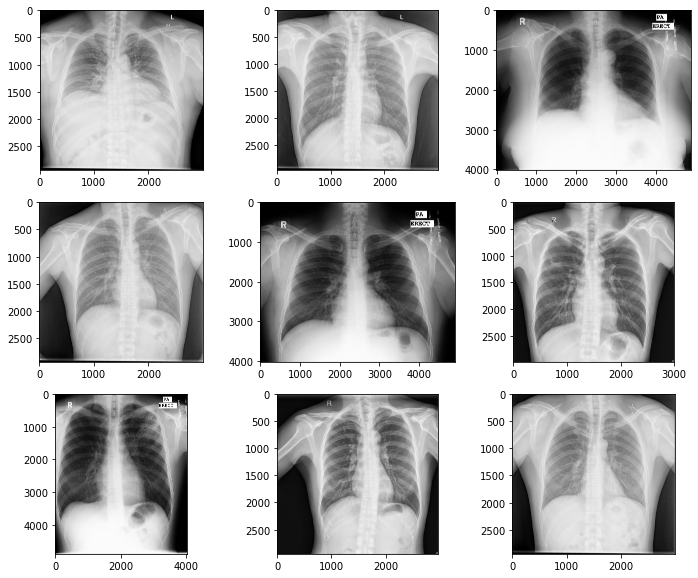

In [ ]:
#Test images
nrows = 3
rands = np.random.randint(len(test_images_list), size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(os.path.join(PATHS['test_images']+'test', sub.loc[rands[i], 'image']))
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
plt.show()

## Training part

In [ ]:
%timeit
epochs = 15                # training epochs
device = 'cuda'            # in order to run model on GPU
size = (300, 300)          # image size
arch = 'resnet50'       # pre-trained model architecture used
layer = 'fc'
fc_size = 2208             # Fully connected layer size
bs = 32                    # training Batch size
eval_bs = 4                # Evaluation Batch size
lr = 1e-4                  # learning rate


avg_auc = 0        # variable for getting the average of loss results after training
best_fold = 0          # variable for getting the best fold number after training    
fold_auc = -np.inf  # initialize fold loss to infinity


######################################  TRAINING PART ###################################
# run training loop over our 10 folds

for fold in range(n_folds):
  print('*'*10)
  print(f'Fold {fold+1}/{n_folds}')
  print('*'*10)
  _score = run_fold(fold,
                    device = device, 
                    bs=bs, 
                    eval_bs=eval_bs, 
                    arch=arch, 
                    layer=layer,
                    epochs=epochs,
                    fc_size=fc_size, 
                    size=size, 
                    lr=lr)
    
  avg_auc += _score

  if fold_auc > _score:
      fold_auc = _score
      best_fold = fold

######################################  TRAINING PART ###################################
        

print("\n [INFO] Avg AUC: ", avg_auc/n_folds)

**********
Fold 1/10
**********


[Training] Epoch 0 : Loss: 0.47945 - Acc : 0.76538 - AUC : 0.77315
[Evaluation] Loss: 0.56062 - Acc : 0.69444 - AUC : nan
[Training] Epoch 1 : Loss: 0.25782 - Acc : 0.90625 - AUC : 0.90643
[Evaluation] Loss: 0.82476 - Acc : 0.62500 - AUC : nan
[Training] Epoch 2 : Loss: 0.17460 - Acc : 0.93552 - AUC : 0.94326
[Evaluation] Loss: 0.48513 - Acc : 0.81944 - AUC : nan
[Training] Epoch 3 : Loss: 0.12778 - Acc : 0.95635 - AUC : 0.95945
[Evaluation] Loss: 0.61276 - Acc : 0.75000 - AUC : nan
[Training] Epoch 4 : Loss: 0.12743 - Acc : 0.95635 - AUC : 0.96415
[Evaluation] Loss: 0.45972 - Acc : 0.86111 - AUC : nan
[Training] Epoch 5 : Loss: 0.07144 - Acc : 0.97272 - AUC : 0.97492
[Evaluation] Loss: 0.59046 - Acc : 0.83333 - AUC : nan
[Training] Epoch 6 : Loss: 0.04980 - Acc : 0.98661 - AUC : 0.98795
[Evaluation] Loss: 0.45867 - Acc : 0.87500 - AUC : nan
[Training] Epoch 7 : Loss: 0.02489 - Acc : 0.99554 - AUC : 0.99653
[Evaluation] Loss: 0.45670 - Acc : 0.93056 - AUC : nan
[Training] Epoch 8 : Los

[Training] Epoch 0 : Loss: 0.50424 - Acc : 0.77133 - AUC : 0.78564
[Evaluation] Loss: 0.90119 - Acc : 0.52778 - AUC : nan
[Training] Epoch 1 : Loss: 0.21927 - Acc : 0.91964 - AUC : 0.92150
[Evaluation] Loss: 0.37559 - Acc : 0.81944 - AUC : nan
[Training] Epoch 2 : Loss: 0.12566 - Acc : 0.94940 - AUC : 0.95324
[Evaluation] Loss: 0.22886 - Acc : 0.88889 - AUC : nan
[Training] Epoch 3 : Loss: 0.11880 - Acc : 0.96131 - AUC : 0.96745
[Evaluation] Loss: 0.51740 - Acc : 0.72222 - AUC : nan
[Training] Epoch 4 : Loss: 0.14101 - Acc : 0.95685 - AUC : nan
[Evaluation] Loss: 0.28057 - Acc : 0.86111 - AUC : nan
[Training] Epoch 5 : Loss: 0.13159 - Acc : 0.94643 - AUC : 0.94901
[Evaluation] Loss: 0.24712 - Acc : 0.91667 - AUC : nan
[Training] Epoch 6 : Loss: 0.06846 - Acc : 0.98363 - AUC : 0.98532
[Evaluation] Loss: 0.20527 - Acc : 0.91667 - AUC : nan
[Training] Epoch 7 : Loss: 0.07204 - Acc : 0.96825 - AUC : 0.97407
[Evaluation] Loss: 0.32424 - Acc : 0.90278 - AUC : nan
[Training] Epoch 8 : Loss: 0

[Training] Epoch 0 : Loss: 0.45646 - Acc : 0.78075 - AUC : 0.78999
[Evaluation] Loss: 1.48265 - Acc : 0.52778 - AUC : nan
[Training] Epoch 1 : Loss: 0.23793 - Acc : 0.90625 - AUC : 0.91173
[Evaluation] Loss: 1.29030 - Acc : 0.56944 - AUC : nan
[Training] Epoch 2 : Loss: 0.15220 - Acc : 0.94048 - AUC : 0.94389
[Evaluation] Loss: 0.61641 - Acc : 0.69444 - AUC : nan
[Training] Epoch 3 : Loss: 0.08770 - Acc : 0.96726 - AUC : 0.97010
[Evaluation] Loss: 0.23587 - Acc : 0.93056 - AUC : nan
[Training] Epoch 4 : Loss: 0.06683 - Acc : 0.97917 - AUC : 0.98113
[Evaluation] Loss: 0.30389 - Acc : 0.87500 - AUC : nan
[Training] Epoch 5 : Loss: 0.06735 - Acc : 0.98016 - AUC : 0.98478
[Evaluation] Loss: 0.60304 - Acc : 0.81944 - AUC : nan
[Training] Epoch 6 : Loss: 0.07936 - Acc : 0.97470 - AUC : 0.97595
[Evaluation] Loss: 0.61642 - Acc : 0.73611 - AUC : nan
[Training] Epoch 7 : Loss: 0.14966 - Acc : 0.95387 - AUC : nan
[Evaluation] Loss: 0.25288 - Acc : 0.87500 - AUC : nan
[Training] Epoch 8 : Loss: 0

KeyboardInterrupt: ignored

## Loading trained models for predictions


###### -    Load model (1)
###### -    Make prediction (2)
###### -    Create submission file (3)


In [ ]:
# 1
MODELS = load_models(arch=arch, layer=layer, fc_size=fc_size)

# 2
predictions_labels, predictions_proba = predict(sub, size=size, MODELS=MODELS, bs=2)

NameError: ignored

#### Making submission

In [ ]:
sample_sub_df.head()

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0
2,train/PMRSQLXN.png,PMRSQLXN,0
3,train/JXISWDUU.png,JXISWDUU,1
4,train/JVWMAACC.png,JVWMAACC,1


In [ ]:
submission = pd.DataFrame()
submission['ID'] = [fn.split('.')[0] for fn in sub['image'].tolist()]

for i, label in enumerate(["0", "1"]):
    submission[label] = 0

for i, label in enumerate(["0", "1"]):
    submission.loc[:,label] = np.array(predictions_proba)[:,i]
submission['LABEL'] = predictions_labels

#show predicted values
submission.head()

# CV/LB score

In [ ]:
y_true = submission['LABEL'].to_list()
y_true = np.array(y_true)

y_pred = submission['1'].to_list()
y_pred = np.array(y_pred)

fpr, tpr, _ = sklearn.metrics.roc_curve(y_true=y_true, y_score = y_pred, pos_label=1)
score = sklearn.metrics.auc(fpr, tpr)
print("[INFO] Your LB AUC score should look like {score}".format(score))

## Save submission file

In [ ]:
# Format dataframe to match Zindi sample submission file 
# and use experiment variables to keep relevant infos on it
subs = submission[['ID', '1']]
subs.columns = ['ID', 'LABEL']
subs.to_csv(f'torch_tb_{arch}_folds_{n_folds}_epochs_{epochs}_size_{size}_LR_{lr}.csv', index=False)